# Import necessary modules

In [2]:
!pip install -U -q neurograd["all"]

import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
except ImportError:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.8/248.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59

# Prepare tiny ImageNet

In [3]:
# ================================================
# Tiny-ImageNet-200: download, extract, restructure,
# map WNIDs to words, then use ImageFolder + DataLoader
# ================================================
import os, zipfile, urllib.request
from pathlib import Path
from neurograd import Tensor, xp
from neurograd.utils.data import ImageFolder, DataLoader

# -------- config --------
DATA_DIR = Path("./data")
ZIP_PATH = DATA_DIR / "tiny-imagenet-200.zip"
ROOT     = DATA_DIR / "tiny-imagenet-200"
TRAIN    = ROOT / "train"
VAL      = ROOT / "val"
VAL_IMG  = VAL / "images"
VAL_ANN  = VAL / "val_annotations.txt"
WORDS_TXT = ROOT / "words.txt"

URLS = [
    "http://cs231n.stanford.edu/tiny-imagenet-200.zip",
    "https://tiny-imagenet.s3.amazonaws.com/tiny-imagenet-200.zip",  # fallback
]

BATCH_SIZE   = 256
IMG_SHAPE    = (227, 227)
IMG_MODE     = "RGB"
USE_ONE_HOT  = True
NUM_CLASSES  = 200

# -------- helpers --------
def download_with_fallback(urls, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if dst.exists() and dst.stat().st_size > 0:
        print(f"[SKIP] {dst.name} already present.")
        return
    for url in urls:
        try:
            print(f"[DOWNLOAD] {url}")
            urllib.request.urlretrieve(url, dst)
            print("[OK] Downloaded.")
            return
        except Exception as e:
            print(f"[WARN] Failed: {e}")
    raise RuntimeError("All downloads failed.")

def extract_zip(zip_path: Path, out_dir: Path):
    if out_dir.exists() and (out_dir / "train").exists() and (out_dir / "val").exists():
        print("[SKIP] Already extracted.")
        return
    print(f"[EXTRACT] {zip_path} -> {out_dir.parent}")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(out_dir.parent)
    print("[OK] Extracted.")

def restructure_train_inplace(train_dir: Path):
    for wnid in [p for p in train_dir.iterdir() if p.is_dir()]:
        images_dir = wnid / "images"
        if images_dir.is_dir():
            for img in images_dir.iterdir():
                if img.is_file():
                    os.replace(img, wnid / img.name)
            try:
                images_dir.rmdir()
            except OSError:
                pass
    print("[TRAIN] Restructured.")

def restructure_val_inplace(val_dir: Path):
    if not (val_dir / "images").exists():
        print("[VAL] Already restructured.")
        return
    mapping = {}
    with open(val_dir / "val_annotations.txt", "r") as f:
        for line in f:
            fname, wnid = line.strip().split("\t")[:2]
            mapping[fname] = wnid
    for fname, wnid in mapping.items():
        src = val_dir / "images" / fname
        dst_dir = val_dir / wnid
        dst_dir.mkdir(parents=True, exist_ok=True)
        os.replace(src, dst_dir / fname)
    try:
        (val_dir / "images").rmdir()
    except OSError:
        pass
    print("[VAL] Restructured.")

def load_wnid_to_words(words_file: Path):
    """Load WNID to human-readable words mapping from words.txt"""
    wnid_to_words = {}
    if not words_file.exists():
        print(f"[WARN] {words_file} not found. Using WNIDs as class names.")
        return wnid_to_words

    with open(words_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) >= 2:
                wnid = parts[0]
                # Take the first word/phrase as the class name
                words = parts[1].split(",")[0].strip()
                wnid_to_words[wnid] = words

    print(f"[OK] Loaded {len(wnid_to_words)} WNID->words mappings.")
    return wnid_to_words

def rename_directories_to_words(base_dir: Path, wnid_to_words: dict):
    """Rename WNID directories to human-readable names"""
    if not wnid_to_words:
        print("[SKIP] No WNID mappings available.")
        return {}

    wnid_to_new_name = {}
    renamed_count = 0

    for wnid_dir in [p for p in base_dir.iterdir() if p.is_dir()]:
        wnid = wnid_dir.name
        if wnid in wnid_to_words:
            # Clean the word for use as directory name
            word = wnid_to_words[wnid]
            # Replace spaces and special chars with underscores
            clean_word = "".join(c if c.isalnum() else "_" for c in word).strip("_")
            new_name = f"{wnid}_{clean_word}"
            new_dir = base_dir / new_name

            # Only rename if not already renamed
            if not str(wnid_dir).endswith(f"_{clean_word}"):
                try:
                    wnid_dir.rename(new_dir)
                    wnid_to_new_name[wnid] = new_name
                    renamed_count += 1
                except OSError as e:
                    print(f"[WARN] Could not rename {wnid}: {e}")
                    wnid_to_new_name[wnid] = wnid
            else:
                wnid_to_new_name[wnid] = wnid_dir.name
        else:
            wnid_to_new_name[wnid] = wnid

    print(f"[OK] Renamed {renamed_count} directories with word labels.")
    return wnid_to_new_name

# -------- run prep --------
download_with_fallback(URLS, ZIP_PATH)
extract_zip(ZIP_PATH, ROOT)
restructure_train_inplace(TRAIN)
restructure_val_inplace(VAL)

# -------- load wnid mappings and rename directories --------
wnid_to_words = load_wnid_to_words(WORDS_TXT)
train_mapping = rename_directories_to_words(TRAIN, wnid_to_words)
val_mapping = rename_directories_to_words(VAL, wnid_to_words)

# -------- one-hot transform --------
def to_one_hot(idx: int, num_classes: int = NUM_CLASSES):
    v = xp.zeros((num_classes,), dtype=xp.float32)
    v[idx] = 1.0
    return v

target_tf = (lambda i: to_one_hot(i, NUM_CLASSES)) if USE_ONE_HOT else None
target_dtype = xp.float32 if USE_ONE_HOT else xp.int64

# -------- datasets/loaders --------
train_ds = ImageFolder(
    root=str(TRAIN),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

val_ds = ImageFolder(
    root=str(VAL),
    img_shape=IMG_SHAPE,
    img_mode=IMG_MODE,
    img_normalize=True,
    target_transform=target_tf,
    img_dtype=xp.float32,
    target_dtype=target_dtype,
    chw=True,
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, seed=42)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

# -------- sanity check --------
Xb, yb = next(iter(train_loader))
print("Tiny-ImageNet batch:")
print("X:", Xb.shape, Xb.dtype)
print("y:", yb.shape, yb.dtype)

# Show class folder names (now with human-readable words)
class_folders = sorted(os.listdir(TRAIN))[:10]
print("Sample class folder names:", class_folders)

# Show some WNID->word mappings
if wnid_to_words:
    print("\nSample WNID->words mappings:")
    for i, (wnid, word) in enumerate(list(wnid_to_words.items())[:10]):
        print(f"  {wnid}: {word}")

# Show class names that the model will see
TARGET_MAPPING = train_ds.target_mapping
TARGET_INV_MAPPING = {v: k for k, v in TARGET_MAPPING.items()}
TARGET_NAMES = train_ds.target_names
NUM_CLASSES = train_ds.num_classes
print(f"\nTotal classes: {NUM_CLASSES}")
print("First 10 class names the model sees:", TARGET_NAMES[:10])

[DOWNLOAD] http://cs231n.stanford.edu/tiny-imagenet-200.zip
[OK] Downloaded.
[EXTRACT] data/tiny-imagenet-200.zip -> data
[OK] Extracted.
[TRAIN] Restructured.
[VAL] Restructured.
[OK] Loaded 82115 WNID->words mappings.
[OK] Renamed 200 directories with word labels.
[OK] Renamed 200 directories with word labels.
Tiny-ImageNet batch:
X: (256, 3, 227, 227) <class 'numpy.float32'>
y: (256, 200) <class 'numpy.float32'>
Sample class folder names: ['n01443537_goldfish', 'n01629819_European_fire_salamander', 'n01641577_bullfrog', 'n01644900_tailed_frog', 'n01698640_American_alligator', 'n01742172_boa_constrictor', 'n01768244_trilobite', 'n01770393_scorpion', 'n01774384_black_widow', 'n01774750_tarantula']

Sample WNID->words mappings:
  n00001740: entity
  n00001930: physical entity
  n00002137: abstraction
  n00002452: thing
  n00002684: object
  n00003553: whole
  n00003993: congener
  n00004258: living thing
  n00004475: organism
  n00005787: benthos

Total classes: 200
First 10 class name

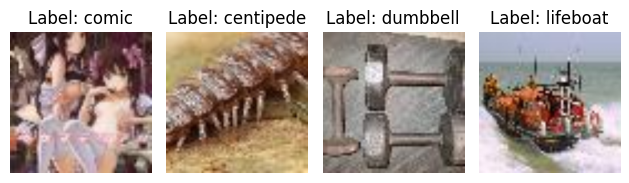

In [4]:
# Plot 4 random images

indices = range(len(train_ds))
chosen = random.sample(indices, 4)

for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img, label = train_ds[idx]
  img = img.data.transpose(1, 2, 0).get()
  label = TARGET_INV_MAPPING.get(label.data.argmax().item()).split("_")[1]
  plt.axis("off")
  plt.imshow(img)
  plt.title(f"Label: {label}")
plt.tight_layout()
plt.show()

# Model architecture, optimizer and losses

In [5]:
from neurograd.nn.layers import Conv2D, MaxPool2D, Flatten, Linear, Sequential

model = Sequential(
    Conv2D(in_channels=3, out_channels=96, kernel_size=11, strides=4, activation="relu"),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(in_channels=96, out_channels=256, kernel_size=5, padding="same", activation="relu"),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(in_channels=256, out_channels=384, kernel_size=3, padding="same", activation="relu"),
    Conv2D(in_channels=384, out_channels=384, kernel_size=3, padding="same", activation="relu"),
    Conv2D(in_channels=384, out_channels=256, kernel_size=3, padding="same", activation="relu"),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Linear(in_features=9216, out_features=4096),
    Linear(in_features=4096, out_features=4096),
    Linear(in_features=4096, out_features=NUM_CLASSES, activation="softmax")
)

In [6]:
from neurograd.optim import Adam
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

optimizer = Adam(model.named_parameters(), lr=1e-3)
loss_fn = CategoricalCrossEntropy()

# Training (mixed precision)

In [ ]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
scaler = GradScaler()

EPOCHS = 100
BATCH_SIZE = train_loader.batch_size


for epoch in range(1, EPOCHS + 1):

  print(f"Epoch: {epoch} / {EPOCHS}:")
  train_losses, train_acc = [], []
  test_losses, test_acc = [], []

  model.train()
  for (X_train, y_train) in tqdm(train_loader):
      with ng.autocast():
        y_pred = model(X_train)
        loss = loss_fn(y_train, y_pred)
        train_losses.append(loss.data)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
        train_acc.append(acc)

  model.eval()
  for (X_test, y_test) in val_loader:
    with ng.autocast():
      y_pred = model(X_test)
      loss = loss_fn(y_test, y_pred)
      acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
      test_losses.append(loss.data)
      test_acc.append(acc)

  # Convert lists to arrays before mean
  train_losses = cp.asarray(train_losses)
  train_acc = cp.asarray(train_acc)
  test_losses = cp.asarray(test_losses)
  test_acc = cp.asarray(test_acc)

  print(
      f"Train loss: {cp.mean(train_losses):.4f}, "
      f"Train acc: {cp.mean(train_acc):.4f}, "
      f"Test loss: {cp.mean(test_losses):.4f}, "
      f"Test acc: {cp.mean(test_acc):.4f}"
  )

Epoch: 1 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: nan, Train acc: 0.0049, Test loss: nan, Test acc: 0.0049
Epoch: 2 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

Train loss: nan, Train acc: 0.0050, Test loss: nan, Test acc: 0.0049
Epoch: 3 / 100:


  0%|          | 0/391 [00:00<?, ?it/s]

# Visualize model predictions

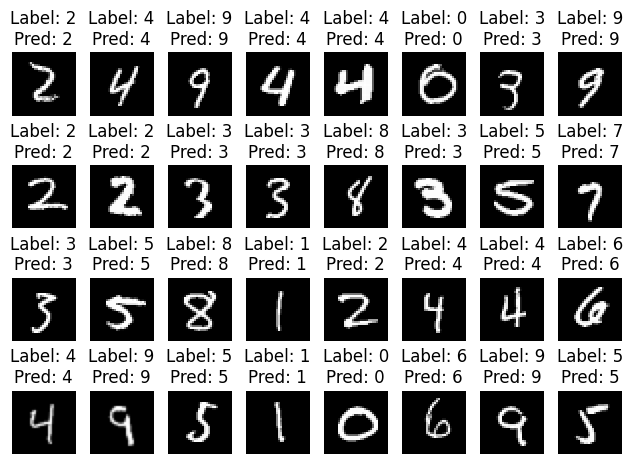

Guessed 32 / 32


In [ ]:
# Plot 4 random predictions from validation set
X, y = random.choice(val_loader)

with ng.autocast():
    y_pred = model(X)

indices = range(len(X))
chosen = random.sample(indices, 4)

correct = 0
for i, idx in enumerate(chosen, 1):
    plt.subplot(1, 4, i)
    img = X[idx].data.transpose(1, 2, 0).get()  # Convert CHW to HWC

    if USE_ONE_HOT:
        label = y[idx].data.argmax(-1).item()
        pred = y_pred[idx].data.argmax(-1).item()
    else:
        label = y[idx].data.item()
        pred = y_pred[idx].data.argmax(-1).item()

    correct += (label == pred)

    # Get human-readable class names
    label_name = TARGET_NAMES[label] if label < len(TARGET_NAMES) else str(label)
    pred_name = TARGET_NAMES[pred] if pred < len(TARGET_NAMES) else str(pred)

    plt.axis("off")
    plt.imshow(img)
    plt.title(f"Label: {label_name}\nPred: {pred_name}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 4")